In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 21.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [38]:
data = pd.read_csv('/gdrive/MyDrive/pr/first_round.csv')
data.head(1003)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
998,999,তোমাদের প্রতিযোগিতার ফলাফল হিসেবে আমরা আমাদের ...,non_depressive
999,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",NaN
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,NaN
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,NaN


In [39]:
count = 0
for i in range(len(data)):
  if data['labels'][i] =="non_depressive":
    data['labels'][i]=1
  elif data['labels'][i] =="depressive":
    data['labels'][i]=0
    count = count + 1

data.head(1003)
print(count)

<ipython-input-39-995e2aa5c827>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'][i]=1
<ipython-input-39-995e2aa5c827>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'][i]=0


257


In [9]:
data['Texts'] = data.Texts.apply(lambda x: preprocessing(str(x)))
data.head()

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1


In [ ]:
print(data['labels'][14])

1


In [10]:
data1 =pd.read_excel('/gdrive/MyDrive/pr/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [ ]:
print(stop)

['অই', 'অগত্যা', 'অত: পর', 'অতএব', 'অথচ', 'অথবা', 'অধিক', 'অধীনে', 'অধ্যায়', 'অনুগ্রহ', 'অনুভূত', 'অনুযায়ী', 'অনুরূপ', 'অনুসন্ধান', 'অনুসরণ', 'অনুসারে', 'অনুসৃত', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অন্যত্র', 'অন্যভাবে', 'অন্যান্য', 'অপেক্ষাকৃতভাবে', 'অবধি', 'অবশ্য', 'অবশ্যই', 'অবস্থা', 'অবিলম্বে', 'অভ্যন্তরস্থ', 'অর্জিত', 'অর্থাত', 'অসদৃশ', 'অসম্ভাব্য', 'আইন', 'আউট', 'আক্রান্ত', 'আগামী', 'আগে', 'আগেই', 'আগ্রহী', 'আছে', 'আজ', 'আট', 'আদেশ', 'আদ্যভাগে', 'আন্দাজ', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদিগের', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'আশি', 'আশু', 'আসা', 'আসে', 'ই', 'ইচ্ছা', 'ইচ্ছাপূর্বক', 'ইতিমধ্যে', 'ইতোমধ্যে', 'ইত্যাদি', 'ইশারা', 'ইহা', 'ইহাতে', 'উক্তি', 'উচিত', 'উচ্চ', 'উঠা', 'উত্তম', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'উপলব্ধ', 'উপায়', 'উভয়', 'উল্লেখ', 'উল্লেখযোগ্যভাবে', 'উহার', 'ঊর্ধ্বতন', 'এ', 'এপর্যন্ত', 'এঁদের', 'এঁরা', 'এই', 'এইগুলো', 'এইভাবে', 'এক', 'একই', 'একটি', 'একদা', 'একবার', 'একভাবে', 'একরকম', 'একসঙ্গে', 'একা', 'একে', 'এক্', 'এখন', 'এখনও', 'এখ

In [11]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [12]:
data['Texts'] = data.Texts.apply(lambda x: stopwordRemoval(str(x)))
data.head(15)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
5,6,নিষিদ্ধ পল্লীতে নিষিদ্ধ মানুষের বসবাস থাকলেও স...,1
6,7,কেমন আছেন আশা ভালো আছেন,1
7,8,ধৈর্য্য সফলতা সমস্যা ধৈয্যধারন ক্ষমতা তুলো গোছের,1
8,9,গতকাল হুগলী জেলার রিষড়ার হেস্টিংস জুট মিলের শ...,1
9,10,অভিনন্দন,1


In [13]:
demo_samples = data
demo_samples

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
...,...,...,...
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
3910,3911,মেয়ের সুন্দর অর্থসহ টিভি চ্যানেলের অমুক প্রতি...,NaN
3911,3912,ছবিটাতে দিলো পশু বিশ্বস্ততা মানুষের এতোটুকু মন...,NaN
3912,3913,পৃথিবীতে গর্ব গর্ব মৃত্যুর খোদার রহমতের ছায়ায...,NaN


In [14]:
demo_samples.drop_duplicates()
demo_samples

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
...,...,...,...
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
3910,3911,মেয়ের সুন্দর অর্থসহ টিভি চ্যানেলের অমুক প্রতি...,NaN
3911,3912,ছবিটাতে দিলো পশু বিশ্বস্ততা মানুষের এতোটুকু মন...,NaN
3912,3913,পৃথিবীতে গর্ব গর্ব মৃত্যুর খোদার রহমতের ছায়ায...,NaN


In [15]:
df = demo_samples[(demo_samples['labels']==1) | (demo_samples['labels']==0)]

In [16]:
df.reset_index(drop=True)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
...,...,...,...
994,995,ইমান সুখ,1
995,996,সুপ্ৰভাত,1
996,997,নিরন্তর গণতন্ত্রের গলা টিপছে মমতা বন্দ্যোপাধ্য...,1
997,998,যৌতুকের স্ত্রীকে পেটানো দেনমোহরের স্বামী কেও প...,1


In [17]:
unlabeled = demo_samples.iloc[999:]
unlabeled

,ID,Texts,labels
999,1000,হ্যালো ফ্রেন্ডস দিশা নাকাব মুভি কেমন লেগেছে,NaN
1000,1001,কখনো আয়নার দাঁড়িয়ে প্রেমে পড়েছিলেন,NaN
1001,1002,মনের বিরুদ্ধে সফল চান্স কারন মন শরীর দুটোর সম্...,NaN
1002,1003,ভালোবাসা প্রেম ভালোবাসা বন্ধুত্বও,NaN
1003,1004,অন্যায় সীমা ছাড়ায় প্রতিবাদ করতেই বাসের চাকা...,NaN
...,...,...,...
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
3910,3911,মেয়ের সুন্দর অর্থসহ টিভি চ্যানেলের অমুক প্রতি...,NaN
3911,3912,ছবিটাতে দিলো পশু বিশ্বস্ততা মানুষের এতোটুকু মন...,NaN
3912,3913,পৃথিবীতে গর্ব গর্ব মৃত্যুর খোদার রহমতের ছায়ায...,NaN


In [18]:
unlabeled.reset_index(drop=True)

,ID,Texts,labels
0,1000,হ্যালো ফ্রেন্ডস দিশা নাকাব মুভি কেমন লেগেছে,NaN
1,1001,কখনো আয়নার দাঁড়িয়ে প্রেমে পড়েছিলেন,NaN
2,1002,মনের বিরুদ্ধে সফল চান্স কারন মন শরীর দুটোর সম্...,NaN
3,1003,ভালোবাসা প্রেম ভালোবাসা বন্ধুত্বও,NaN
4,1004,অন্যায় সীমা ছাড়ায় প্রতিবাদ করতেই বাসের চাকা...,NaN
...,...,...,...
2910,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,NaN
2911,3911,মেয়ের সুন্দর অর্থসহ টিভি চ্যানেলের অমুক প্রতি...,NaN
2912,3912,ছবিটাতে দিলো পশু বিশ্বস্ততা মানুষের এতোটুকু মন...,NaN
2913,3913,পৃথিবীতে গর্ব গর্ব মৃত্যুর খোদার রহমতের ছায়ায...,NaN


In [19]:
X = df["Texts"].values
y = df["labels"].values
print(X)

['জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত্রী শেখ হাসিনা এভাবে নৌকার ভোটে ডাকাতি লজ্জা লাগেনা ছিঃ বাসদ নেত্রী ড মনীষা চক্রবর্তী'
 'সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ'
 'তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে যখনিই আকাশ ভেঙ্গে বর্ষা কাঁদে পাগল'
 'রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁজে পাইতাম শুভ সকাল'
 'আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী সত্ত্বেও সৃষ্টির দয়াবান ক্ষমাশীল দুষ্কর্মকারীদের শাস্তি দেয়ার পুরো ক্ষমতা লজ্জিত দুষ্কর্ম পরিত্যাগ ক্ষমা প্রার্থনা সাথে ক্ষমাশীলতার আচরণ'
 'নিষিদ্ধ পল্লীতে নিষিদ্ধ মানুষের বসবাস থাকলেও সেখানকার খরিদ্দাররা একদম বিশুদ্ধ পল্লীর'
 'কেমন আছেন আশা ভালো আছেন'
 'ধৈর্য্য সফলতা সমস্যা ধৈয্যধারন ক্ষমতা তুলো গোছের'
 'গতকাল হুগলী জেলার রিষড়ার হেস্টিংস জুট মিলের শ্রমিকদের ট্রাস্টি বোর্ডের বিজেপির অসংগঠিত শ্রমিকদের সংগঠন পাকসু মোর্চা র প্রার্থীদের জয় প্রমান করল পশ্চিমবঙ্গের খেটে খাওয়া গরিব প্রধানমন্ত্রী শ্রী নরেন্দ্র মোদী জির বিজয়ী প্রার্থীদের জানাই আন্তরিক গৈরিক শুভেচ্ছা'
 'অভিনন্দন'
 'দেশে মানুষের মৃত্যুর খবর শুনে মন্ত্রী মহোদয

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [21]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [22]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

899
100
899
100


In [23]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from keras.utils.vis_utils import plot_model

In [24]:
test_ck = pd.DataFrame(X_train)
test_ck.columns = ["Response"]

length_of_the_messages = test_ck["Response"].str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  42
Index =  121


In [25]:
num_words = 20000 #Max. words to use per comment
max_features = 60000 #Max. number of unique words in embeddinbg vector
max_len = 64 #Max. number of words per toxic comment to be use
embedding_dims = 64 #embedding vector output dimension 
num_epochs = 100 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.05
batch_size2 = 32

In [26]:
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = pad_sequences(X_train, max_len, padding='post')
X_test  = pad_sequences(X_test,  max_len, padding='post')

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (899, 64)
X_test shape:  (100, 64)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size =0.95, random_state=233)

In [28]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [29]:
#GLoVE Loading
glove_file = open('/gdrive/MyDrive/pr/bn_glove.39M.300d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 178153 word vectors.


In [30]:
print(len(tokenizer.word_index)+1)

5069


In [31]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape[0]

5069

In [33]:
LSTM_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(64, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(16, activation = 'relu'),
    Dropout(0.1),
    Dense(2, activation = 'sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [34]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 300)           1520700   
                                                                 
 lstm (LSTM)                 (None, 64, 64)            93440     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

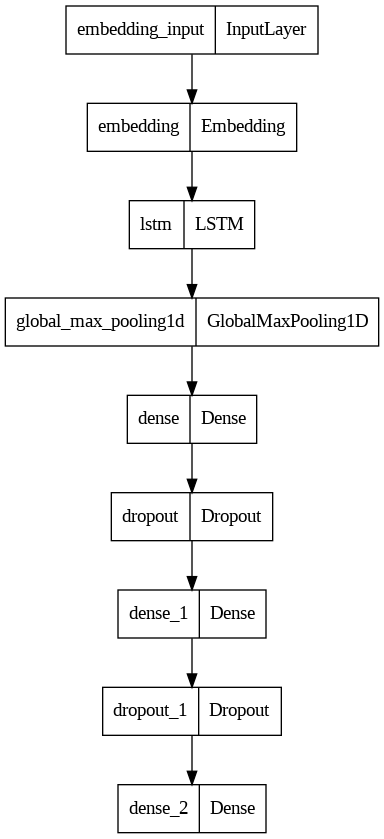

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(LSTM_model, to_file='LSTM_model.png')

In [ ]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
54/54 [==============================] - 14s 18ms/step - loss: 0.5842 - accuracy: 0.7412 - val_loss: 0.5319 - val_accuracy: 0.7111
Epoch 2/100
54/54 [==============================] - 0s 7ms/step - loss: 0.4978 - accuracy: 0.7482 - val_loss: 0.4926 - val_accuracy: 0.7111
Epoch 3/100
54/54 [==============================] - 0s 7ms/step - loss: 0.3849 - accuracy: 0.8349 - val_loss: 0.6824 - val_accuracy: 0.7333
Epoch 4/100
54/54 [==============================] - 0s 7ms/step - loss: 0.2542 - accuracy: 0.9016 - val_loss: 0.7840 - val_accuracy: 0.7333
Epoch 5/100
54/54 [==============================] - 0s 7ms/step - loss: 0.2354 - accuracy: 0.9122 - val_loss: 0.5564 - val_accuracy: 0.6889
Epoch 6/100
54/54 [==============================] - 0s 7ms/step - loss: 0.1726 - accuracy: 0.9391 - val_loss: 0.5830 - val_accuracy: 0.7111
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9496 - val_loss: 0.8116 - val_accuracy: 0.7111


In [ ]:
pred_lstm = LSTM_model.predict(X_test)

4/4 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score
pred_round = np.round(pred_lstm)  
score = accuracy_score(y_test,pred_round)
score

0.72

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'Depression-Indicative']
print(classification_report(y_test, pred_round, target_names=target_names))

                       precision    recall  f1-score   support

               Normal       0.53      0.34      0.42        29
Depression-Indicative       0.77      0.87      0.82        71

            micro avg       0.72      0.72      0.72       100
            macro avg       0.65      0.61      0.62       100
         weighted avg       0.70      0.72      0.70       100
          samples avg       0.72      0.72      0.72       100



In [ ]:
print(np.around(pred_lstm,3))

[[0.002 0.998]
 [0.668 0.344]
 [0.012 0.987]
 [0.02  0.98 ]
 [0.601 0.417]
 [0.803 0.202]
 [0.004 0.996]
 [0.017 0.982]
 [0.004 0.996]
 [0.33  0.68 ]
 [0.008 0.992]
 [0.006 0.993]
 [0.831 0.171]
 [0.005 0.995]
 [0.002 0.998]
 [0.    1.   ]
 [0.    1.   ]
 [0.01  0.99 ]
 [0.018 0.982]
 [0.001 0.999]
 [0.052 0.949]
 [0.864 0.138]
 [0.162 0.842]
 [0.001 0.999]
 [0.755 0.252]
 [0.053 0.948]
 [0.661 0.35 ]
 [0.    1.   ]
 [0.005 0.995]
 [0.115 0.887]
 [0.007 0.993]
 [0.239 0.768]
 [0.001 0.999]
 [0.    1.   ]
 [0.07  0.931]
 [0.977 0.022]
 [0.    1.   ]
 [0.    1.   ]
 [0.162 0.842]
 [0.046 0.954]
 [0.    1.   ]
 [0.052 0.949]
 [0.01  0.99 ]
 [0.712 0.293]
 [0.035 0.965]
 [0.129 0.874]
 [0.    1.   ]
 [0.017 0.983]
 [0.    1.   ]
 [0.004 0.996]
 [0.006 0.994]
 [0.    1.   ]
 [0.    1.   ]
 [0.024 0.976]
 [0.007 0.993]
 [0.014 0.986]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.021 0.979]
 [0.115 0.888]
 [0.007 0.993]
 [0.166 0.838]
 [0.253 0.

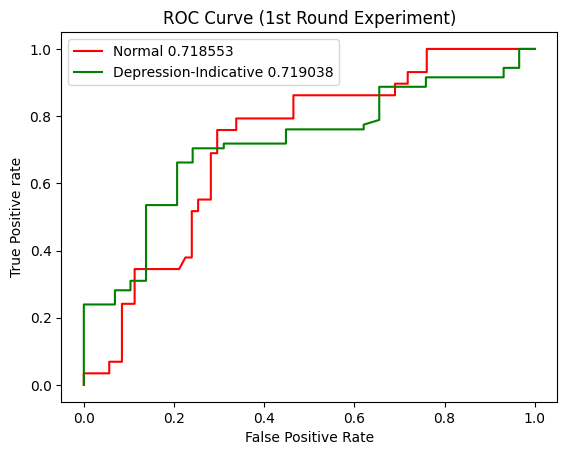

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test[:,i], pred_lstm[:,i], multi_class='ovo')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='Red', label= 'Normal '+ str(round(roc[0],6)))
plt.plot(fpr[1], tpr[1], linestyle='solid',color='green', label= 'Depression-Indicative '+ str(round(roc[1],6)))



plt.title('ROC Curve (1st Round Experiment)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('ROC Curve (1st Round Experiment)',dpi=300);

In [ ]:
unlabeled_texts = unlabeled["Texts"].values
#Convert tokenized commnent to sequnces
unlabeled_texts = tokenizer.texts_to_sequences(unlabeled_texts)

 # padding the sequences
unlabeled_texts = pad_sequences(unlabeled_texts, max_len, padding='post')

In [ ]:
most_conf = np.nanmax(pred_lstm)
num_labels = pred_lstm.size
numerator = (num_labels * (1 - most_conf))
denominator = (num_labels - 1)
least_conf = numerator / denominator

In [ ]:
pred_unlabeled = LSTM_model.predict(unlabeled_texts)

92/92 [==============================] - 0s 3ms/step


In [ ]:
print(np.around(pred_unlabeled,3))
print(pred_unlabeled.shape)

[[0.002 0.998]
 [0.017 0.982]
 [0.    1.   ]
 ...
 [0.917 0.084]
 [0.    1.   ]
 [0.052 0.949]]
(2915, 2)


In [ ]:
need_handlabeling = pd.DataFrame(columns=['ID','Texts', 'labels'])

In [ ]:
def least_confi(arr):
      
    # get number of rows and columns
    no_of_rows = arr.shape[0]
    no_of_column = arr.shape[1]
    num_labels = 2 
    cnt = 0;
   
    nh_index = 0
    for i in range(no_of_rows):
          
        # Initialize max1 to 0 at beginning
        # of finding max element of each row
        most_conf = 0
        for j in range(no_of_column):
            if arr[i][j] > most_conf :
                most_conf = arr[i][j]
                numerator = (num_labels * (1 - most_conf))
                denominator = (num_labels - 1)
                least_conf = numerator / denominator

                
                  
        # print maximum element of each row
        print(cnt,".",least_conf)
        
        if(least_conf>0.6): #if the confidence score is greater than 0.6, sample requires handlabeling 
          need_handlabeling.loc[nh_index] = unlabeled.iloc[cnt]
          print("Done")
          nh_index = nh_index + 1
        cnt = cnt+1

In [ ]:
least_confi(pred_unlabeled)

0 . 0.003745436668395996
1 . 0.03503835201263428
2 . 0.0005038976669311523
3 . 0.15939557552337646
4 . 0.03267514705657959
5 . 0.05492579936981201
6 . 0.02378237247467041
7 . 0.00023412704467773438
8 . 0.01786816120147705
9 . 0.0021528005599975586
10 . 6.031990051269531e-05
11 . 0.00033974647521972656
12 . 0.19428634643554688
13 . 0.0029358863830566406
14 . 0.0027245283126831055
15 . 0.0003587007522583008
16 . 0.025060057640075684
17 . 0.1444028615951538
18 . 0.06600821018218994
19 . 0.035494327545166016
20 . 0.8493412733078003
Done
21 . 1.1205673217773438e-05
22 . 6.175041198730469e-05
23 . 0.00021505355834960938
24 . 1.2159347534179688e-05
25 . 0.00014257431030273438
26 . 2.1457672119140625e-06
27 . 0.07042324542999268
28 . 0.009700179100036621
29 . 0.0013300180435180664
30 . 2.5272369384765625e-05
31 . 0.06480026245117188
32 . 3.814697265625e-06
33 . 0.0009082555770874023
34 . 0.20390653610229492
35 . 5.9604644775390625e-06
36 . 0.026398181915283203
37 . 0.07143914699554443
38 . 0.2

In [ ]:
print(pred_unlabeled)

[[1.79507560e-03 9.98127282e-01]
 [1.74827706e-02 9.82480824e-01]
 [2.34858890e-04 9.99748051e-01]
 ...
 [9.17148590e-01 8.35341439e-02]
 [1.07949265e-04 9.99881148e-01]
 [5.15303686e-02 9.48551297e-01]]


In [ ]:
original_samples = pd.read_csv('/gdrive/MyDrive/pr/first_round.csv')

In [ ]:
first_round_handlabeleing = pd.DataFrame()

In [ ]:
first_round_handlabeleing = original_samples.loc[original_samples['ID'].isin(need_handlabeling['ID'])]

In [ ]:
first_round_handlabeleing

,ID,Texts,labels
1019,1020,"অরন্যদেব ছবিতে যে ছিল আমার কন্যা , সে আজ থেকে ...",NaN
1152,1153,আমিই কি একজন ? যে লজ্জার কারণে কারো সাথে ভিডিও...,NaN
1161,1162,ধন্যবাদ ও সবাই কে সময় মত রক্ত দেয়াতে আপুর বো...,NaN
1172,1173,আমার এ ঘর ভাঙিয়াছে যে আমি বাধি তার ঘর আপন করি...,NaN
1310,1311,বিএনপি মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর দাবি ...,NaN
...,...,...,...
3858,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",NaN
3879,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",NaN
3897,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,NaN
3899,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",NaN


In [ ]:
first_round_handlabeleing.to_csv('first_round_handlabeleing.csv',sep='\t')

In [ ]:
labeled_data_original = pd.DataFrame()

In [ ]:
labeled_data_original = original_samples.loc[original_samples['ID'].isin(df['ID'])]

In [ ]:
labeled_data_original.to_csv('labeled_data_original.csv',sep='\t')

In [ ]:
labeled_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [ ]:
first_round_handlabeled = pd.DataFrame()

In [ ]:
first_round_handlabeled = labeled_samples.loc[labeled_samples['ID'].isin(need_handlabeling['ID'])]

In [ ]:
first_round_handlabeled

,ID,Texts,labels
1019,1020,"অরন্যদেব ছবিতে যে ছিল আমার কন্যা , সে আজ থেকে ...",non_depressive
1152,1153,আমিই কি একজন ? যে লজ্জার কারণে কারো সাথে ভিডিও...,non_depressive
1161,1162,ধন্যবাদ ও সবাই কে সময় মত রক্ত দেয়াতে আপুর বো...,non_depressive
1172,1173,আমার এ ঘর ভাঙিয়াছে যে আমি বাধি তার ঘর আপন করি...,depressive
1310,1311,বিএনপি মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর দাবি ...,non_depressive
...,...,...,...
3858,3859,"এদের কাছে কোন জিনিস না নিয়ে যাবেন্নাহ , কেননা...",non_depressive
3879,3880,"আয় বিজেপি দেখে যা , দেখবি যত জ্বলবি তত !",depressive
3897,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
3899,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive


In [ ]:
first_round_handlabeled.to_csv('labeled_data_firstround.csv',sep='\t')